# **Question B5**

This is the proof of concept to show the potential usage of IoT technology to improve guest experience in theme parks.

By leveraging WiFi Access Points (WAPs), we massage historical time-series data to generate heatmaps and scatter plots, showing the distribution of crowds as well as their movements.

## **Importing Libraries**

In [ ]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score, classification_report, mean_squared_error, accuracy_score, confusion_matrix

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR, SVC
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.multioutput import MultiOutputRegressor

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

We write a function to load and preprocess basic temporal features to simplify timeseries data manipulation. The test and train datasets are combined to simplify analysis and visualisation.

In [ ]:
# LoadData

# 1. Load and preprocess data
def load_and_preprocess(df):
    """Load and preprocess raw dataframe"""
    df = df.sort_values(by=['TIMESTAMP'])
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], unit='s')
    df['DATE'] = pd.to_datetime(df['TIMESTAMP'].dt.date)
    df['TIME'] = pd.to_datetime(df['TIMESTAMP'])
    # df = df.drop(columns=[col for col in df.columns if df[col].nunique() == 1] + ['RELATIVEPOSITION'])
    return df

dfTrain = pd.read_csv("/Users/ryann_/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/NUS/Y3.2/DSA3101/Prokect/IOT/TrainingData.csv")
dfValid = pd.read_csv("/Users/ryann_/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/NUS/Y3.2/DSA3101/Prokect/IOT/ValidationData.csv")
df = pd.concat([dfTrain, dfValid])
df = load_and_preprocess(df)

## **Data Exploration & Visualisation**

Here we explore the data to gain better understanding of the available data and its structure.

First, we plot the coordinates to visualise the geographical layout.

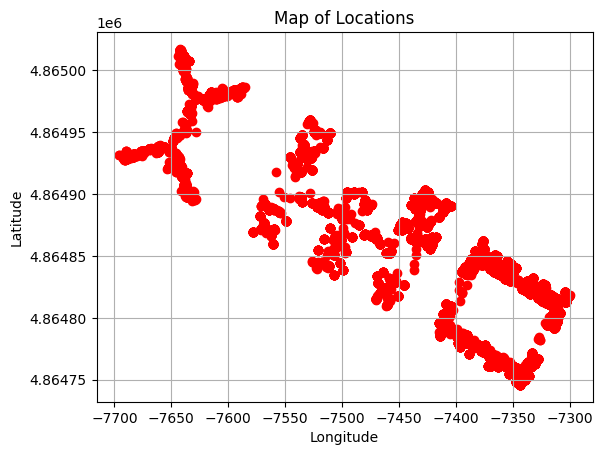

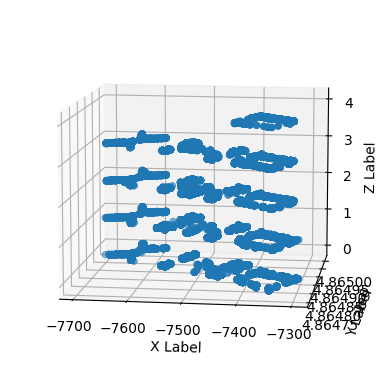

In [ ]:
# Vis_1_2

# Plot the points
plt.scatter(df["LONGITUDE"], df["LATITUDE"], color='red', marker='o')

# Labels and title
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Map of Locations")
plt.grid()

# Show the map
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['LONGITUDE'], df['LATITUDE'], df['FLOOR'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(elev=10, azim=-82)  # Adjust elevation and azimuth angles

plt.show()

With this, we know that this data set consists of WAPs of 3 buildings where buildings 0 and 1 having 4 floors and building 2 having 5 floors.

Next, we plot the distribution of WAPs across the floors and buildings.

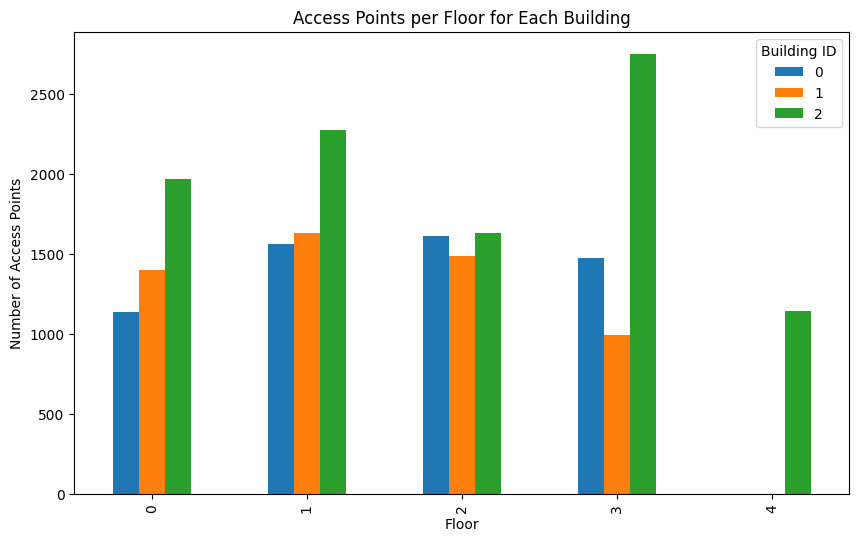

In [ ]:
# Vis_3

dfgrouped = df.groupby(["BUILDINGID", "FLOOR"]).size().reset_index(name="num_access_points")
pivot_df = dfgrouped.pivot(index="FLOOR", columns="BUILDINGID", values="num_access_points")

# Plot the bar chart
pivot_df.plot(kind="bar", figsize=(10, 6))

# Add labels and title
plt.xlabel("Floor")
plt.ylabel("Number of Access Points")
plt.title("Access Points per Floor for Each Building")
plt.legend(title="Building ID")

plt.show()

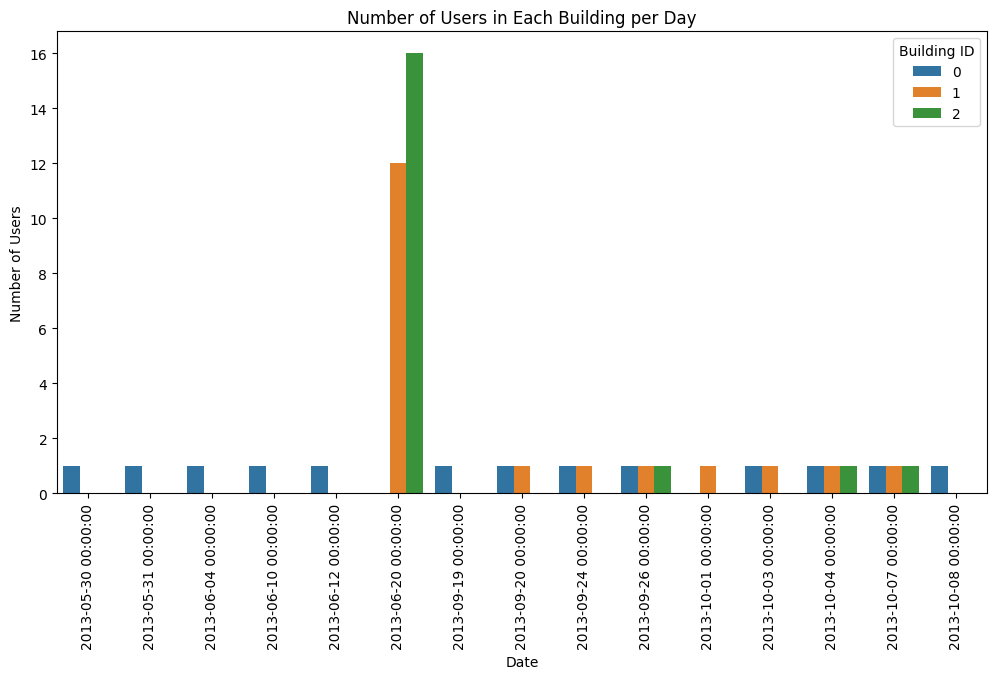

In [ ]:
# Vis_4

df_grouped = df.groupby(['DATE', 'BUILDINGID'])['USERID'].nunique().reset_index()
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_grouped, x='DATE', y='USERID', hue='BUILDINGID', dodge=True)

# Labels
plt.xlabel("Date")
plt.ylabel("Number of Users")
plt.title("Number of Users in Each Building per Day")
plt.xticks(rotation=90)
plt.legend(title="Building ID")

# Show plot
plt.show()

From the 2 plots above, we can see that
1) The number of WAPs across different buildings seems to be the most similar on floor 2
2) There is a large number of users across buildings 1 and 2 on 2013-06-20.

Therefore, we will map the crowd on 2013-06-20 on floor 2.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


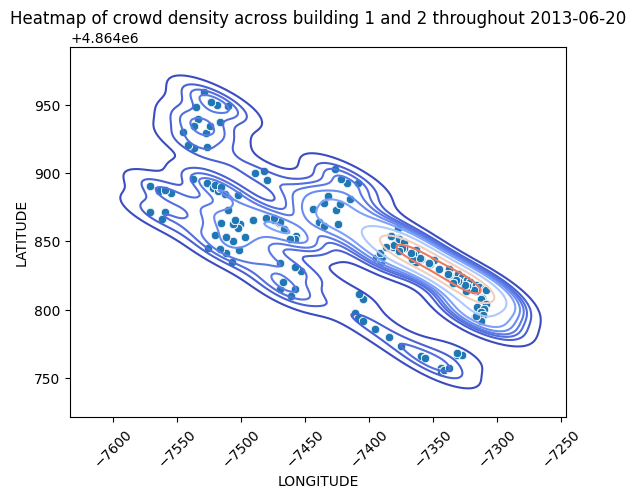

In [ ]:
# Vis_5

df_floor_2 = df[df['FLOOR'] == 2]

df_floor_2_drilled = df_floor_2[df_floor_2['DATE'] == '2013-06-20'].reset_index(drop=True)
columns_to_drop = [col for col in df_floor_2_drilled.columns if df_floor_2_drilled[col].nunique() == 1]
df_floor_2_drilled = df_floor_2_drilled.drop(columns=columns_to_drop).drop(columns = ['RELATIVEPOSITION'])
# print(df_floor_2_drilled)
sns.scatterplot(data = df_floor_2_drilled, y = "LATITUDE", x = "LONGITUDE")
sns.kdeplot(data = df_floor_2_drilled, x = "LONGITUDE", y = "LATITUDE", cmap = "coolwarm")
#plt.plot(df_ave["LONGITUDE"], df_ave["LATITUDE"])
# sns.lineplot(data = df_ave, x = "LONGITUDE", y = "LATITUDE")

plt.xticks(rotation = 45)
plt.title("Heatmap of crowd density across building 1 and 2 throughout 2013-06-20")
plt.show()

**Trend Finding**

By averaging out the positions of each user, we can find the center of crowds.

In [ ]:
def mean_exclude_100(arr):
    return arr[arr != 100].mean()

/var/folders/_g/rrmsdry5679dbh4rxc2n7lvw0000gn/T/ipykernel_41467/2889379345.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_ave = df_floor_2_drilled_indexed.groupby(pd.Grouper(freq = '20T')).agg(mean_exclude_100).fillna(100)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119:

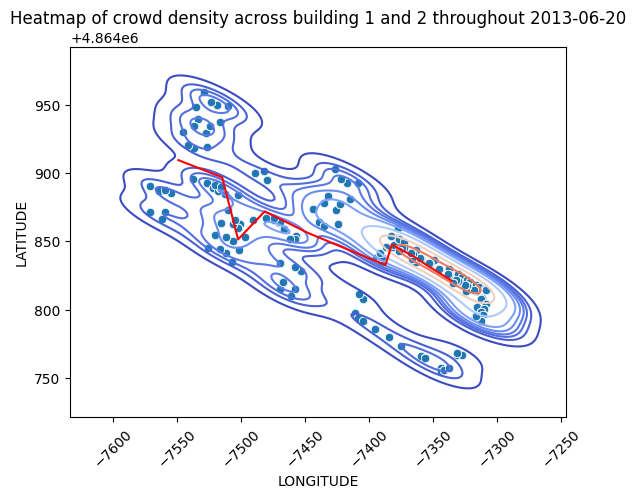

In [ ]:
# vis_6

#df_floor_2_drilled['TIMESTAMP'] = pd.to_datetime(df_floor_2_drilled['TIMESTAMP'])
# print(df_floor_2_drilled)

df_floor_2_drilled_indexed = df_floor_2_drilled.set_index('TIMESTAMP')
columns_to_drop = [col for col in df_floor_2_drilled_indexed.columns if df_floor_2_drilled_indexed[col].nunique() == 1]
df_floor_2_drilled_indexed = df_floor_2_drilled_indexed.drop(columns=columns_to_drop).drop(columns = ['BUILDINGID'])
#print(df_floor_2_drilled_indexed)


df_ave = df_floor_2_drilled_indexed.groupby(pd.Grouper(freq = '20T')).agg(mean_exclude_100).fillna(100)
df_ave = df_ave[df_ave['PHONEID'] != 100]
# print(df_ave)
sns.scatterplot(data = df_floor_2_drilled, y = "LATITUDE", x = "LONGITUDE")
sns.kdeplot(data = df_floor_2_drilled, x = "LONGITUDE", y = "LATITUDE", cmap = "coolwarm")
#plt.plot(df_ave["LONGITUDE"], df_ave["LATITUDE"])
sns.lineplot(data = df_ave, x = "LONGITUDE", y = "LATITUDE", color = 'red')

plt.xticks(rotation = 45)
plt.title("Heatmap of crowd density across building 1 and 2 throughout 2013-06-20")
plt.show()

In the plot above, we can see the density of crowds via the heatmap where it shows that the crowd is densest in Building 2 where Longitude = [-7400 , -7300].
The red line in the plot shows the center of the crowd as well as how crowds might shift throughout the day.

Through this, we have mapped out the density and movement patterns of crowds.

## **Modelling**

In this section, we will train and test our models on individual buildings with LONGIUDE, LATITUDE, and FLOOR as its target variables.

Since my plan is to split the data according buildings, I first check to see if the data sets are large enough.

In [8]:
print("Training set:")
print(dfTrain.groupby(by='BUILDINGID').size())
print("\nTest set:")
print(dfValid.groupby(by='BUILDINGID').size())

Training set:
BUILDINGID
0    5249
1    5196
2    9492
dtype: int64

Test set:
BUILDINGID
0    536
1    307
2    268
dtype: int64


In [26]:
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seed(42)

Since the data seems large enough, we prepare the data via feature engineering and scaling.

In [27]:
# Data Preparation Pipeline
def preprocess_data(df, is_train=False, scaler=None, selector=None):
    """Apply all preprocessing steps consistently"""
    wap_cols = [col for col in df.columns if col.startswith("WAP")]
    
    # Signal processing
    df = df.replace(100, -120).fillna(-120)
    
    # Feature engineering
    #df['Strongest_Signal'] = df[wap_cols].max(axis=1)
    # df['Num_Strong_Signals'] = (df[wap_cols] > -30).sum(axis=1)
    df['Minute'] = pd.to_datetime(df['TIMESTAMP']).dt.minute
    #df['Signal_Variance'] = df[wap_cols].std(axis=1)  # Signal consistency
    #df['Signal_NonZero_Count'] = (df[wap_cols] > -90).sum(axis=1)  # Strong signal count
    #df['Signal_Range'] = df[wap_cols].max(axis=1) - df[wap_cols].min(axis=1)
    
    # Apply transformations
    df[wap_cols] = np.log10(df[wap_cols] + 121)
    df[wap_cols] = df[wap_cols].rolling(window=5, min_periods=1).mean()
    
    # Outlier handling
    Q1 = df[wap_cols].quantile(0.25)
    Q3 = df[wap_cols].quantile(0.75)
    IQR = Q3 - Q1
    df[wap_cols] = np.where(
        (df[wap_cols] < (Q1 - 1.5 * IQR)) | (df[wap_cols] > (Q3 + 1.5 * IQR)),
        np.nan,
        df[wap_cols]
    )
    df[wap_cols] = df[wap_cols].fillna(df[wap_cols].median())
    
    # Prepare features and targets
    X = df.drop(columns=['LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID', 'TIMESTAMP', 'TIME', 'DATE'])
    y_reg = df[['LONGITUDE', 'LATITUDE']]
    y_cls = df['FLOOR']
    
    # Feature selection and scaling
    if is_train:
        scaler = MinMaxScaler(feature_range=(0, 1))
        
        selector = VarianceThreshold(threshold=0.01)
        
        X_scaled = scaler.fit_transform(X[wap_cols])
        X_scaled = selector.fit_transform(X_scaled)
        
        return X_scaled, y_reg, y_cls, scaler, selector, X.columns
    else:
        X_scaled = scaler.transform(X[wap_cols])
        X_scaled = selector.transform(X_scaled)
        return X_scaled, y_reg, y_cls

We split the data to train and test sets via filtering for '2013-07-20'. This is because dfValid only contains entries after '2013-08-01' while dfTrain only contains entries up till '2013-06-20' 

The train and test sets are then pre-processed by adding features that may help in training the model as well as removing noise caused by outliers. The data is also scaled and encoded to ensure consistency, reduce bias, and improve model performance.

In [ ]:
# ml_1

# Prepare training and test data
df_00 = df[df['BUILDINGID'] == 0] # Change this number [0, 1, 2] for different buildings. ===============================================
df_0 = df_00[df_00['DATE'] < '2013-07-20']
df_0_test = df_00[df_00['DATE'] > '2013-07-20']

# Process training data
X_train, y_train_reg, y_train_cls, scaler, selector, train_cols = preprocess_data(df_0, is_train=True)

# Process test data
X_test_new, y_test_reg_new, y_test_cls_new = preprocess_data(df_0_test, is_train=False, scaler=scaler, selector=selector)

# Split training data for validation
X_train, X_val, y_train_reg, y_val_reg, y_train_cls, y_val_cls = train_test_split(
    X_train, y_train_reg, y_train_cls, test_size=0.2, random_state=42
)

# Scale regression targets
coord_scaler = StandardScaler()
y_train_reg_scaled = coord_scaler.fit_transform(y_train_reg)
y_val_reg_scaled = coord_scaler.transform(y_val_reg)

# Encode categorical element
le = LabelEncoder()
y_train_floors = le.fit_transform(y_train_cls)  
y_val_floors = le.transform(y_val_cls)         

"""
# Prepare data - ensure numpy arrays
X_train_reg = np.array(X_train) if not isinstance(X_train, np.ndarray) else X_train
y_train_reg = np.array(y_train_reg_scaled) if not isinstance(y_train_reg_scaled, np.ndarray) else y_train_reg_scaled
X_val = np.array(X_val) if not isinstance(X_val, np.ndarray) else X_val
y_val_reg = np.array(y_val_reg) if not isinstance(y_val_reg, np.ndarray) else y_val_reg
"""

def adjusted_r2_score(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    n_samples = len(y_true)
    return 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)



Here we compare different regression models and compare their performace on the validation and test sets.


Training XGBoost...


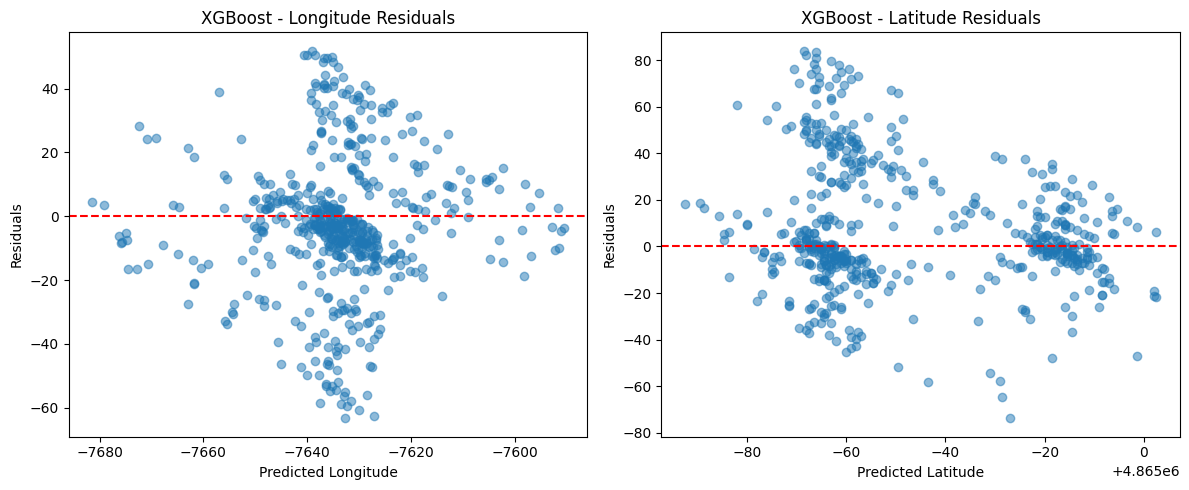

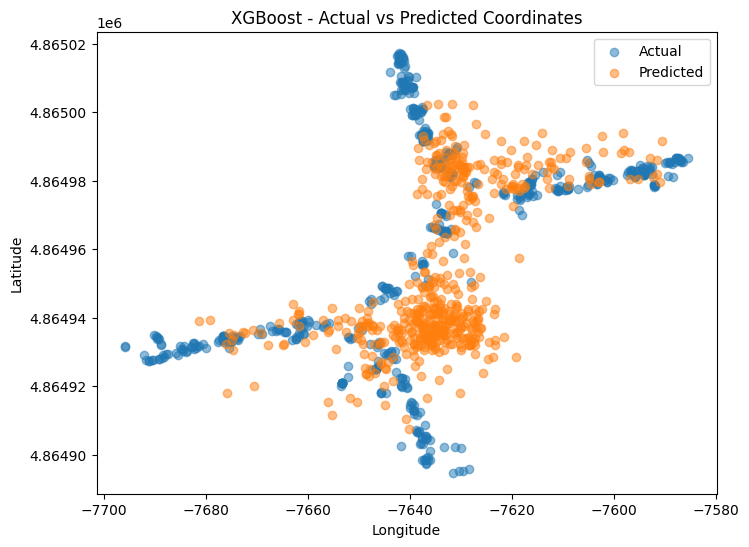


Training Gradient Boosting...


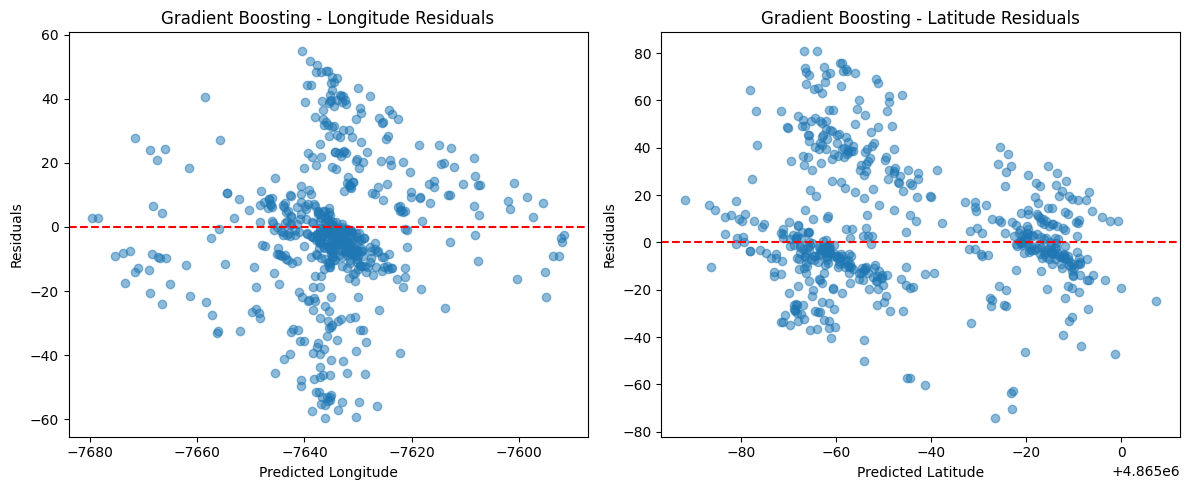

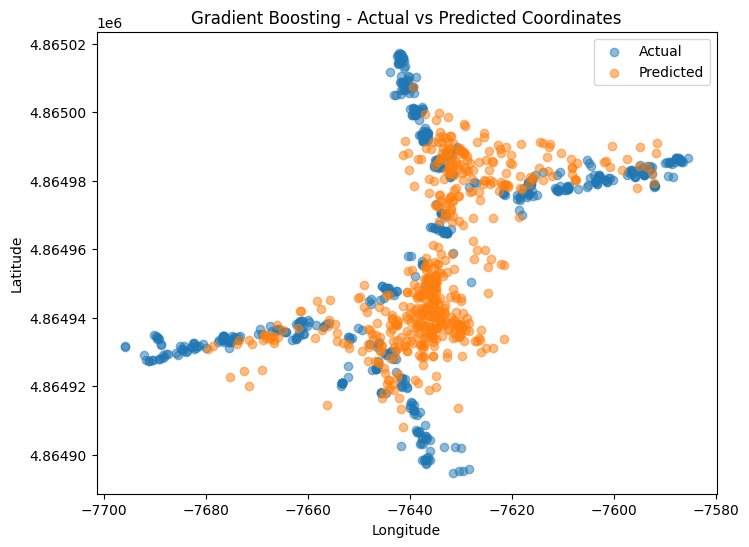


Training Random Forest...


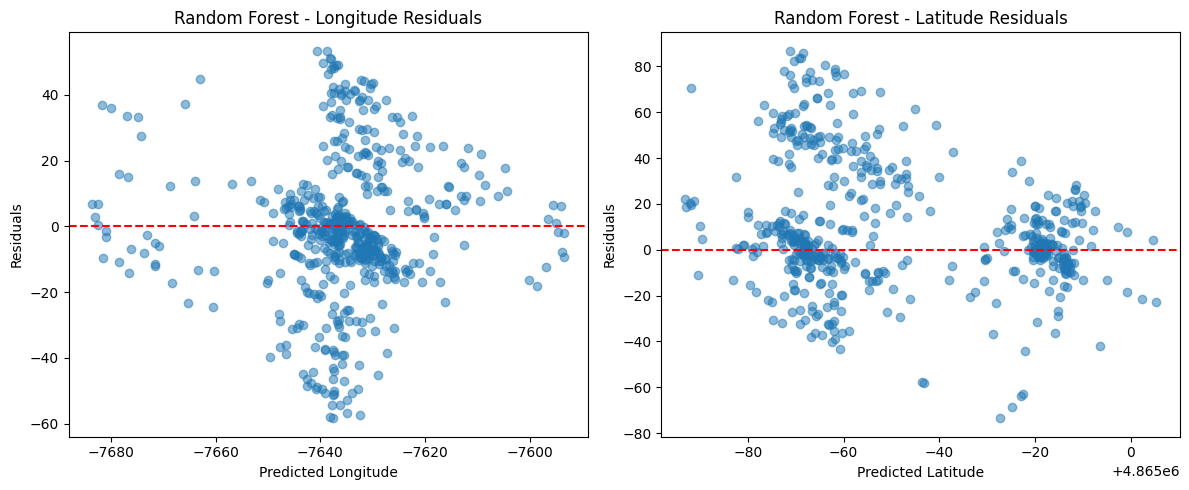

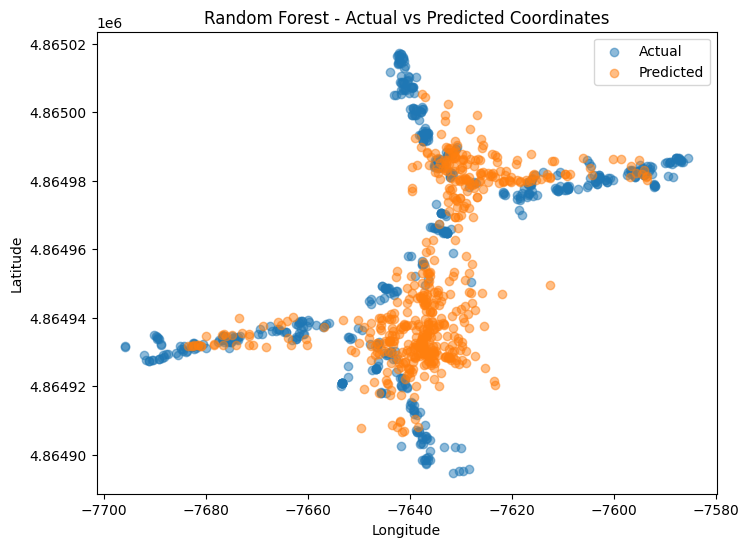


Training SVR (RBF)...


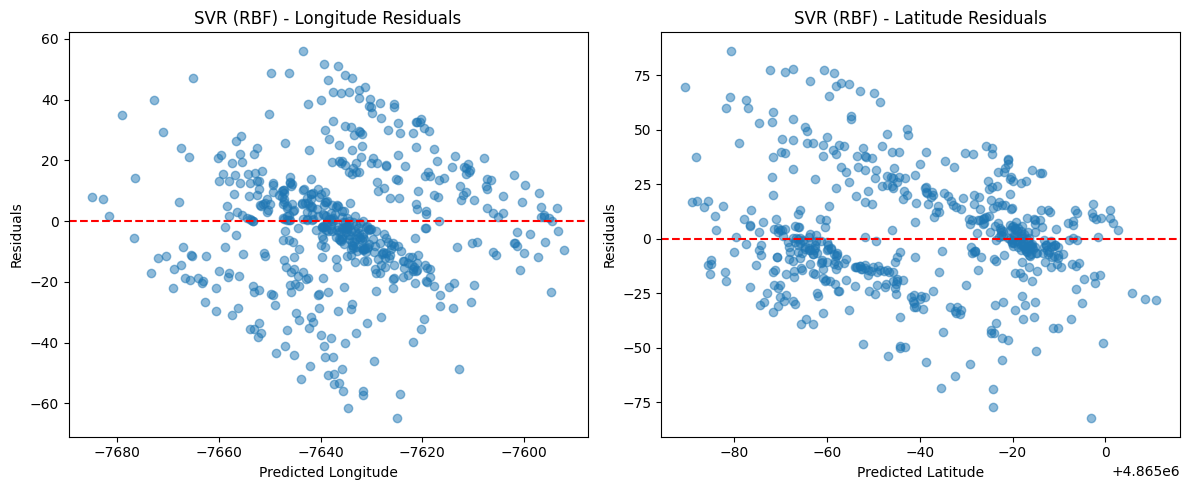

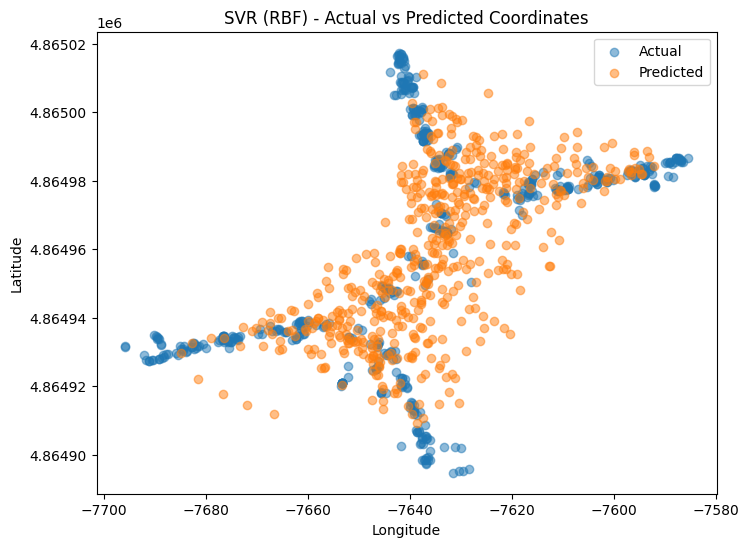


Training MLP...


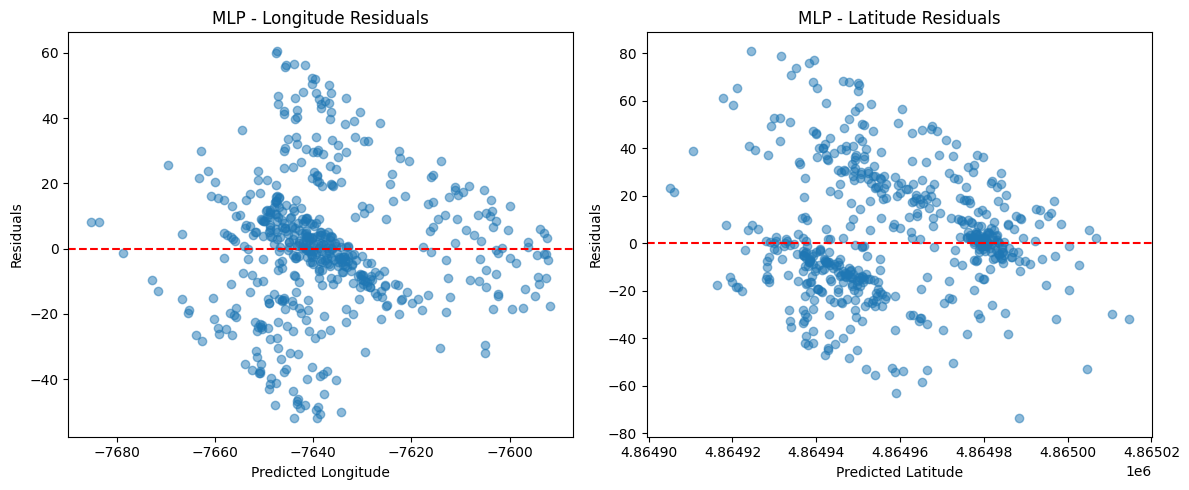

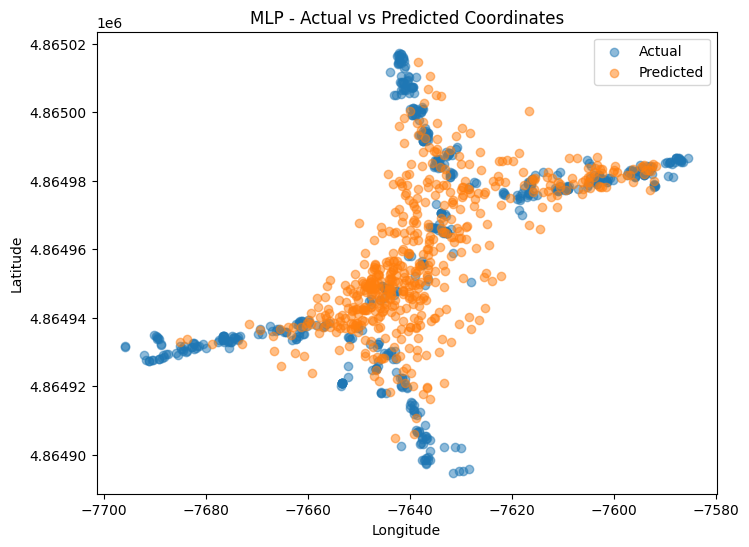


=== Model Comparison ===
| Model             |     MSE |       R² |   Adjusted R² |
|:------------------|--------:|---------:|--------------:|
| SVR (RBF)         | 560.707 | 0.347191 |      0.301494 |
| MLP               | 569.136 | 0.335198 |      0.288662 |
| Gradient Boosting | 623.332 | 0.271894 |      0.220926 |
| XGBoost           | 657.285 | 0.234513 |      0.180929 |
| Random Forest     | 676.194 | 0.2187   |      0.164009 |


In [11]:
# Defining various models to compare performance.
models = {
    "XGBoost": MultiOutputRegressor(XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(
        n_estimators=150,
        max_depth=5,
        learning_rate=0.05,
        random_state=42
    )),
    "Random Forest": MultiOutputRegressor(RandomForestRegressor(
        n_estimators=200,
        max_depth=8,
        min_samples_split=5,
        random_state=42
    )),
    "SVR (RBF)": MultiOutputRegressor(SVR(
        kernel='rbf',
        C=1.0,
        epsilon=0.1
    )),
    "MLP": MLPRegressor(
        hidden_layer_sizes=(256, 128),
        activation='relu',
        solver='adam',
        early_stopping=True,
        random_state=42
    )
}

def evaluate_model(model, X_test, y_test, coord_scaler, model_name):
    # Ensure y_test is numpy array
    y_test = np.array(y_test) if not isinstance(y_test, np.ndarray) else y_test
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred = np.array(y_pred)  # Ensure numpy array
    y_pred = coord_scaler.inverse_transform(y_pred)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = adjusted_r2_score(y_test, y_pred, X_test.shape[1])
    
    # Calculate residuals
    residuals = y_test - y_pred
    
    # Plot residuals
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred[:, 0], residuals[:, 0], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'{model_name} - Longitude Residuals')
    plt.xlabel('Predicted Longitude')
    plt.ylabel('Residuals')
    
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred[:, 1], residuals[:, 1], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'{model_name} - Latitude Residuals') 
    plt.xlabel('Predicted Latitude')
    plt.ylabel('Residuals')
    
    plt.tight_layout()
    plt.show()

    # Scatterplot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test[:, 0], y_test[:, 1], alpha=0.5, label='Actual')
    plt.scatter(y_pred[:, 0], y_pred[:, 1], alpha=0.5, label='Predicted')
    plt.title(f'{model_name} - Actual vs Predicted Coordinates')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()  
    
    return mse, r2, adj_r2

# Train & Compare
results = []
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train_reg_scaled)
    mse, r2, adj_r2 = evaluate_model(model, X_test_new, y_test_reg_new, coord_scaler, name) # X_val, y_val_reg can we swapped with X_test_new, y_test_reg_new
    results.append({
        'Model': name,
        'MSE': mse,
        'R²': r2,
        'Adjusted R²': adj_r2
    })

# Display results
results_df = pd.DataFrame(results).sort_values('MSE')
print("\n=== Model Comparison ===")
print(results_df.to_markdown(index=False))

On the validation set, XGBoost performs the best with an adjusted R2 of 0.98. On the test set, SVR(RBF) has the best adjusted R2 score of 0.30, followed closely by MLP with 0.28. Therefore we will compare the performance of SVR(RBF), MLP, and Neural Network models on predicting the location and floor of crowds. In this case, floors will be catigorical feature.

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - coord_output_loss: 0.2910 - coord_output_mse: 0.2910 - floor_output_accuracy: 0.5603 - floor_output_loss: 1.0778 - loss: 1.3689 - val_coord_output_loss: 0.1795 - val_coord_output_mse: 0.1813 - val_floor_output_accuracy: 0.8238 - val_floor_output_loss: 0.5277 - val_loss: 0.7058 - learning_rate: 0.0010
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - coord_output_loss: 0.1801 - coord_output_mse: 0.1801 - floor_output_accuracy: 0.8340 - floor_output_loss: 0.4586 - loss: 0.6387 - val_coord_output_loss: 0.1798 - val_coord_output_mse: 0.1810 - val_floor_output_accuracy: 0.8448 - val_floor_output_loss: 0.4066 - val_loss: 0.5872 - learning_rate: 0.0010
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - coord_output_loss: 0.1825 - coord_output_mse: 0.1825 - floor_output_accuracy: 0.8596 - floor_output_loss: 0.3599 - loss: 0.5425 - val_coord_output_loss: 0.1895 - val_coord_output_mse: 0.1900 - val_floor_output_accuracy: 0.8476 - val_f

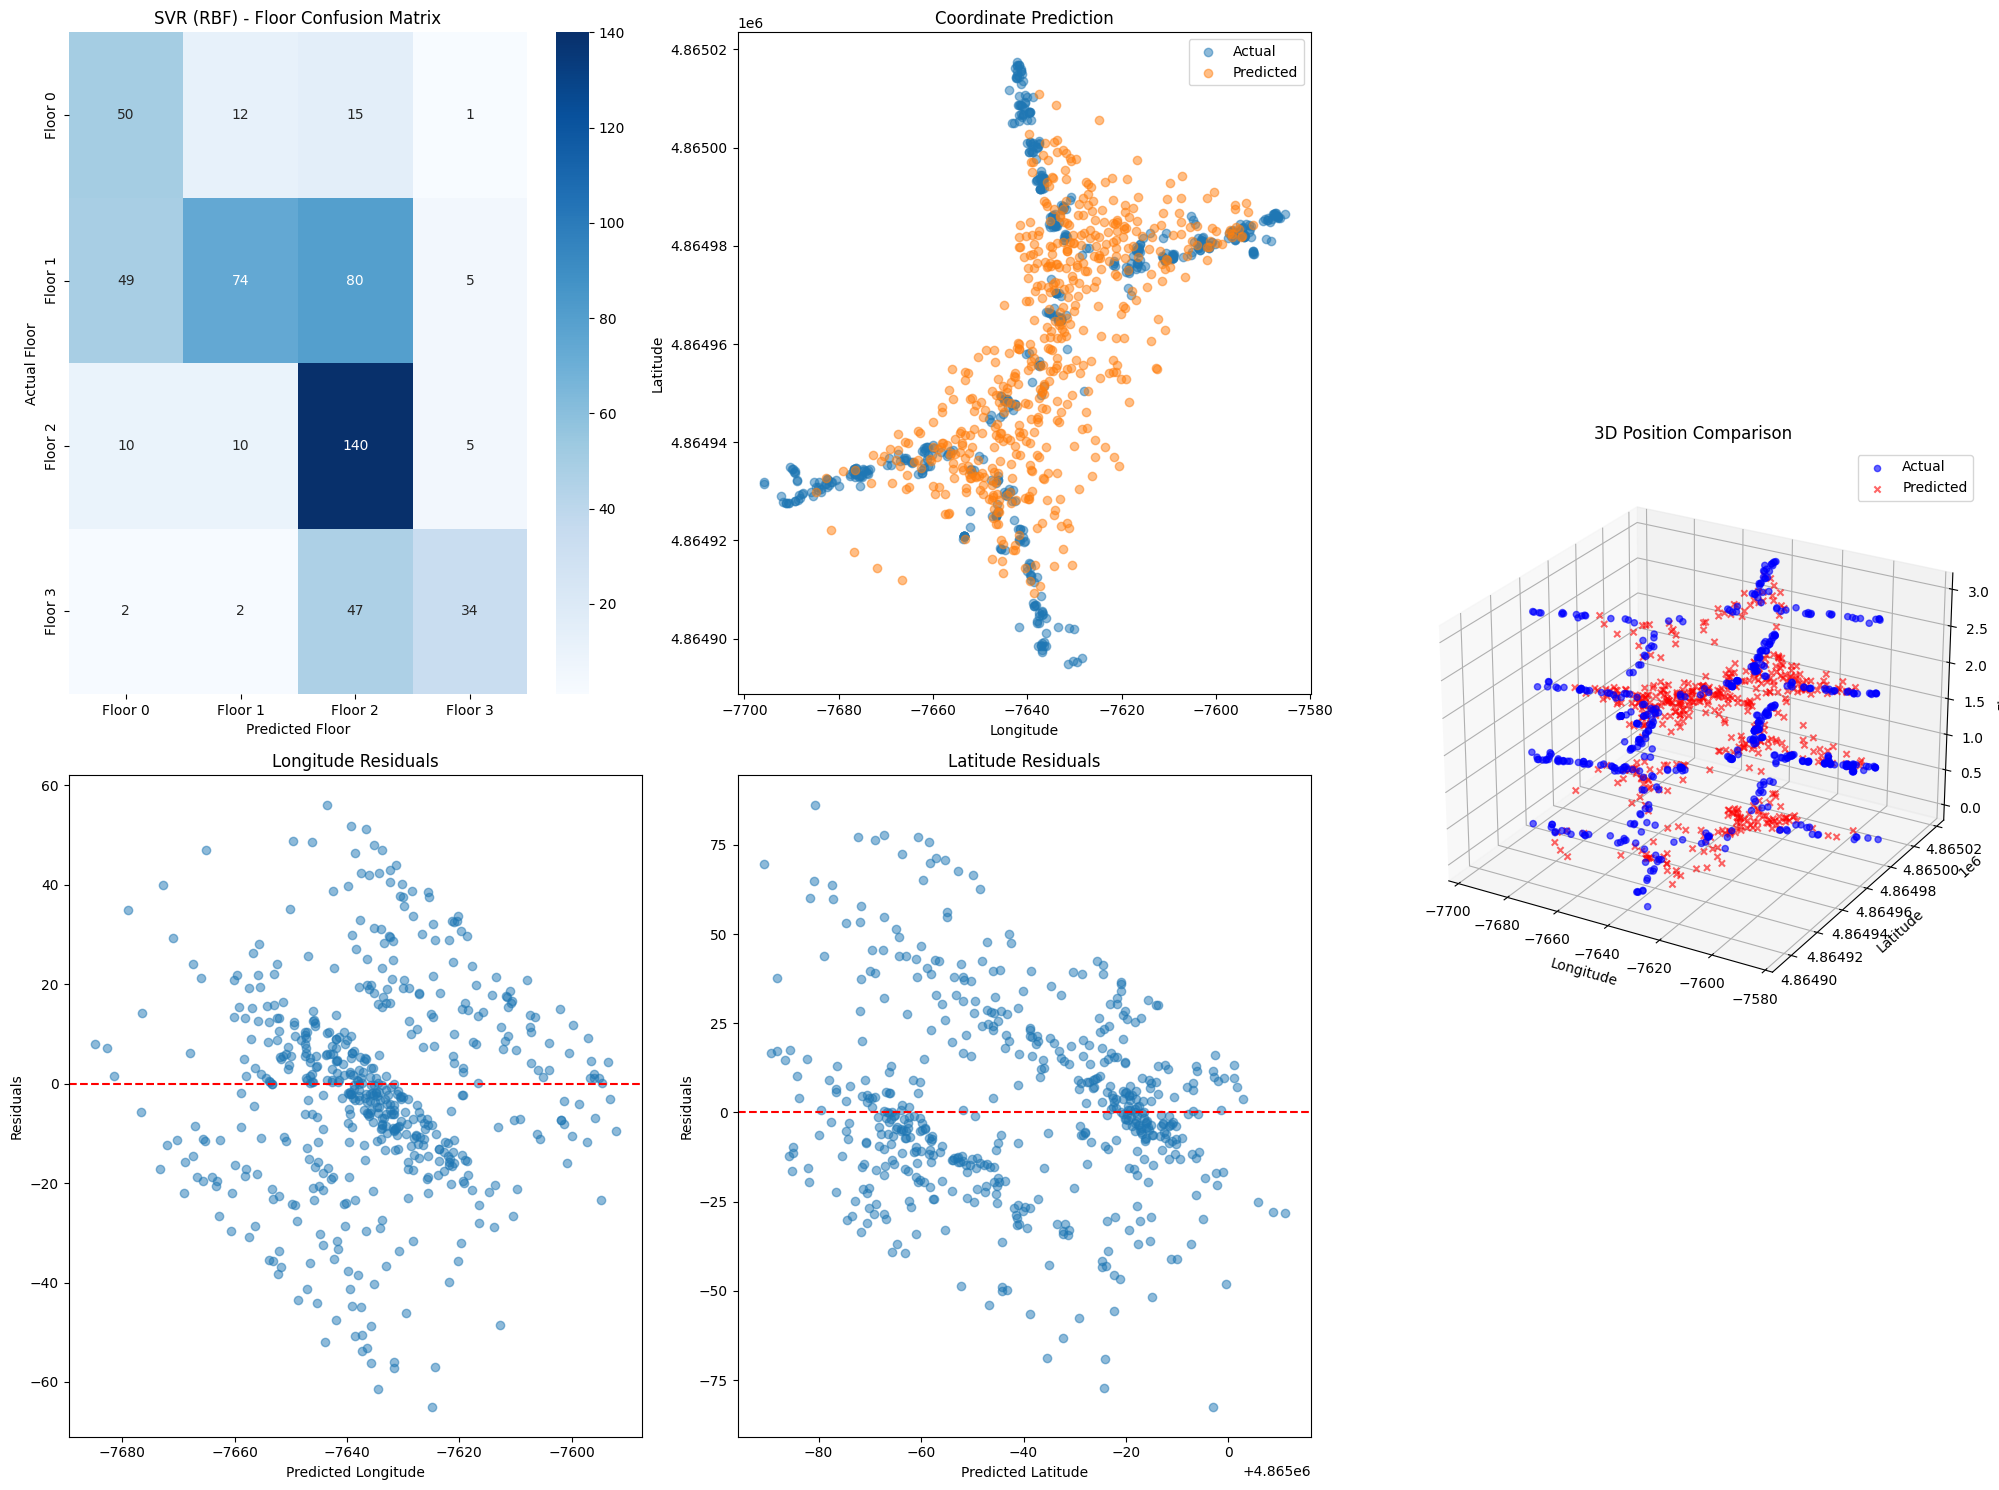


=== SVR (RBF) Performance ===
Coordinates MSE: 560.7068
Coordinates R²: 0.3472
Floor Accuracy: 0.5560

Classification Report:
              precision    recall  f1-score   support

     Floor 0       0.45      0.64      0.53        78
     Floor 1       0.76      0.36      0.48       208
     Floor 2       0.50      0.85      0.63       165
     Floor 3       0.76      0.40      0.52        85

    accuracy                           0.56       536
   macro avg       0.61      0.56      0.54       536
weighted avg       0.63      0.56      0.54       536


Evaluating MLP


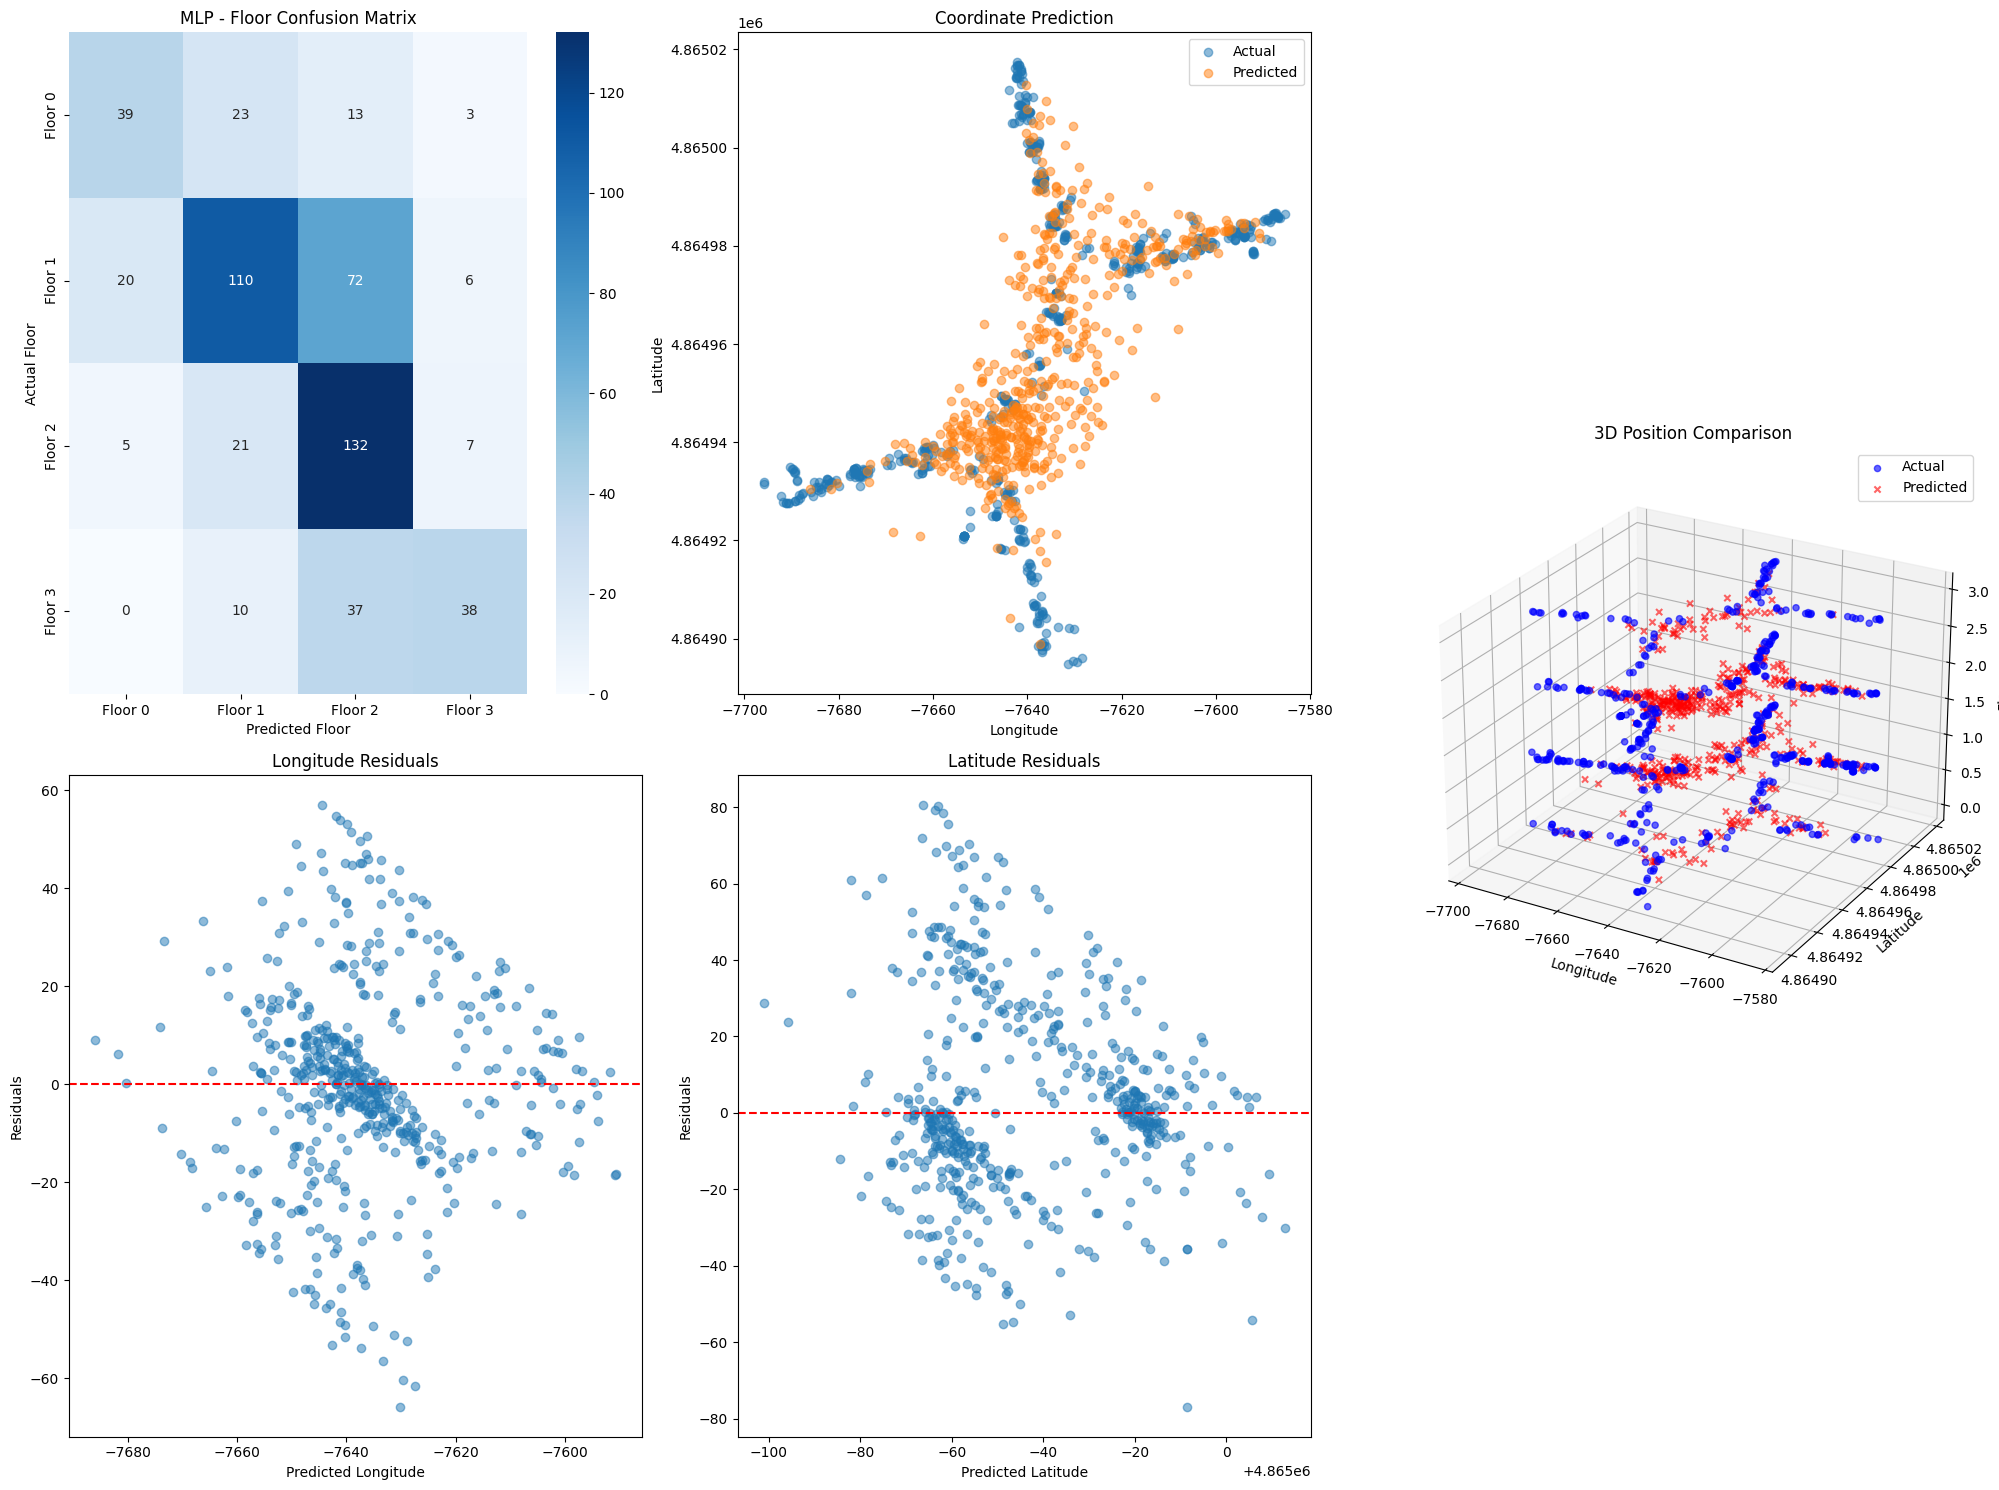


=== MLP Performance ===
Coordinates MSE: 591.4841
Coordinates R²: 0.3103
Floor Accuracy: 0.5951

Classification Report:
              precision    recall  f1-score   support

     Floor 0       0.61      0.50      0.55        78
     Floor 1       0.67      0.53      0.59       208
     Floor 2       0.52      0.80      0.63       165
     Floor 3       0.70      0.45      0.55        85

    accuracy                           0.60       536
   macro avg       0.63      0.57      0.58       536
weighted avg       0.62      0.60      0.59       536


Evaluating Neural Network


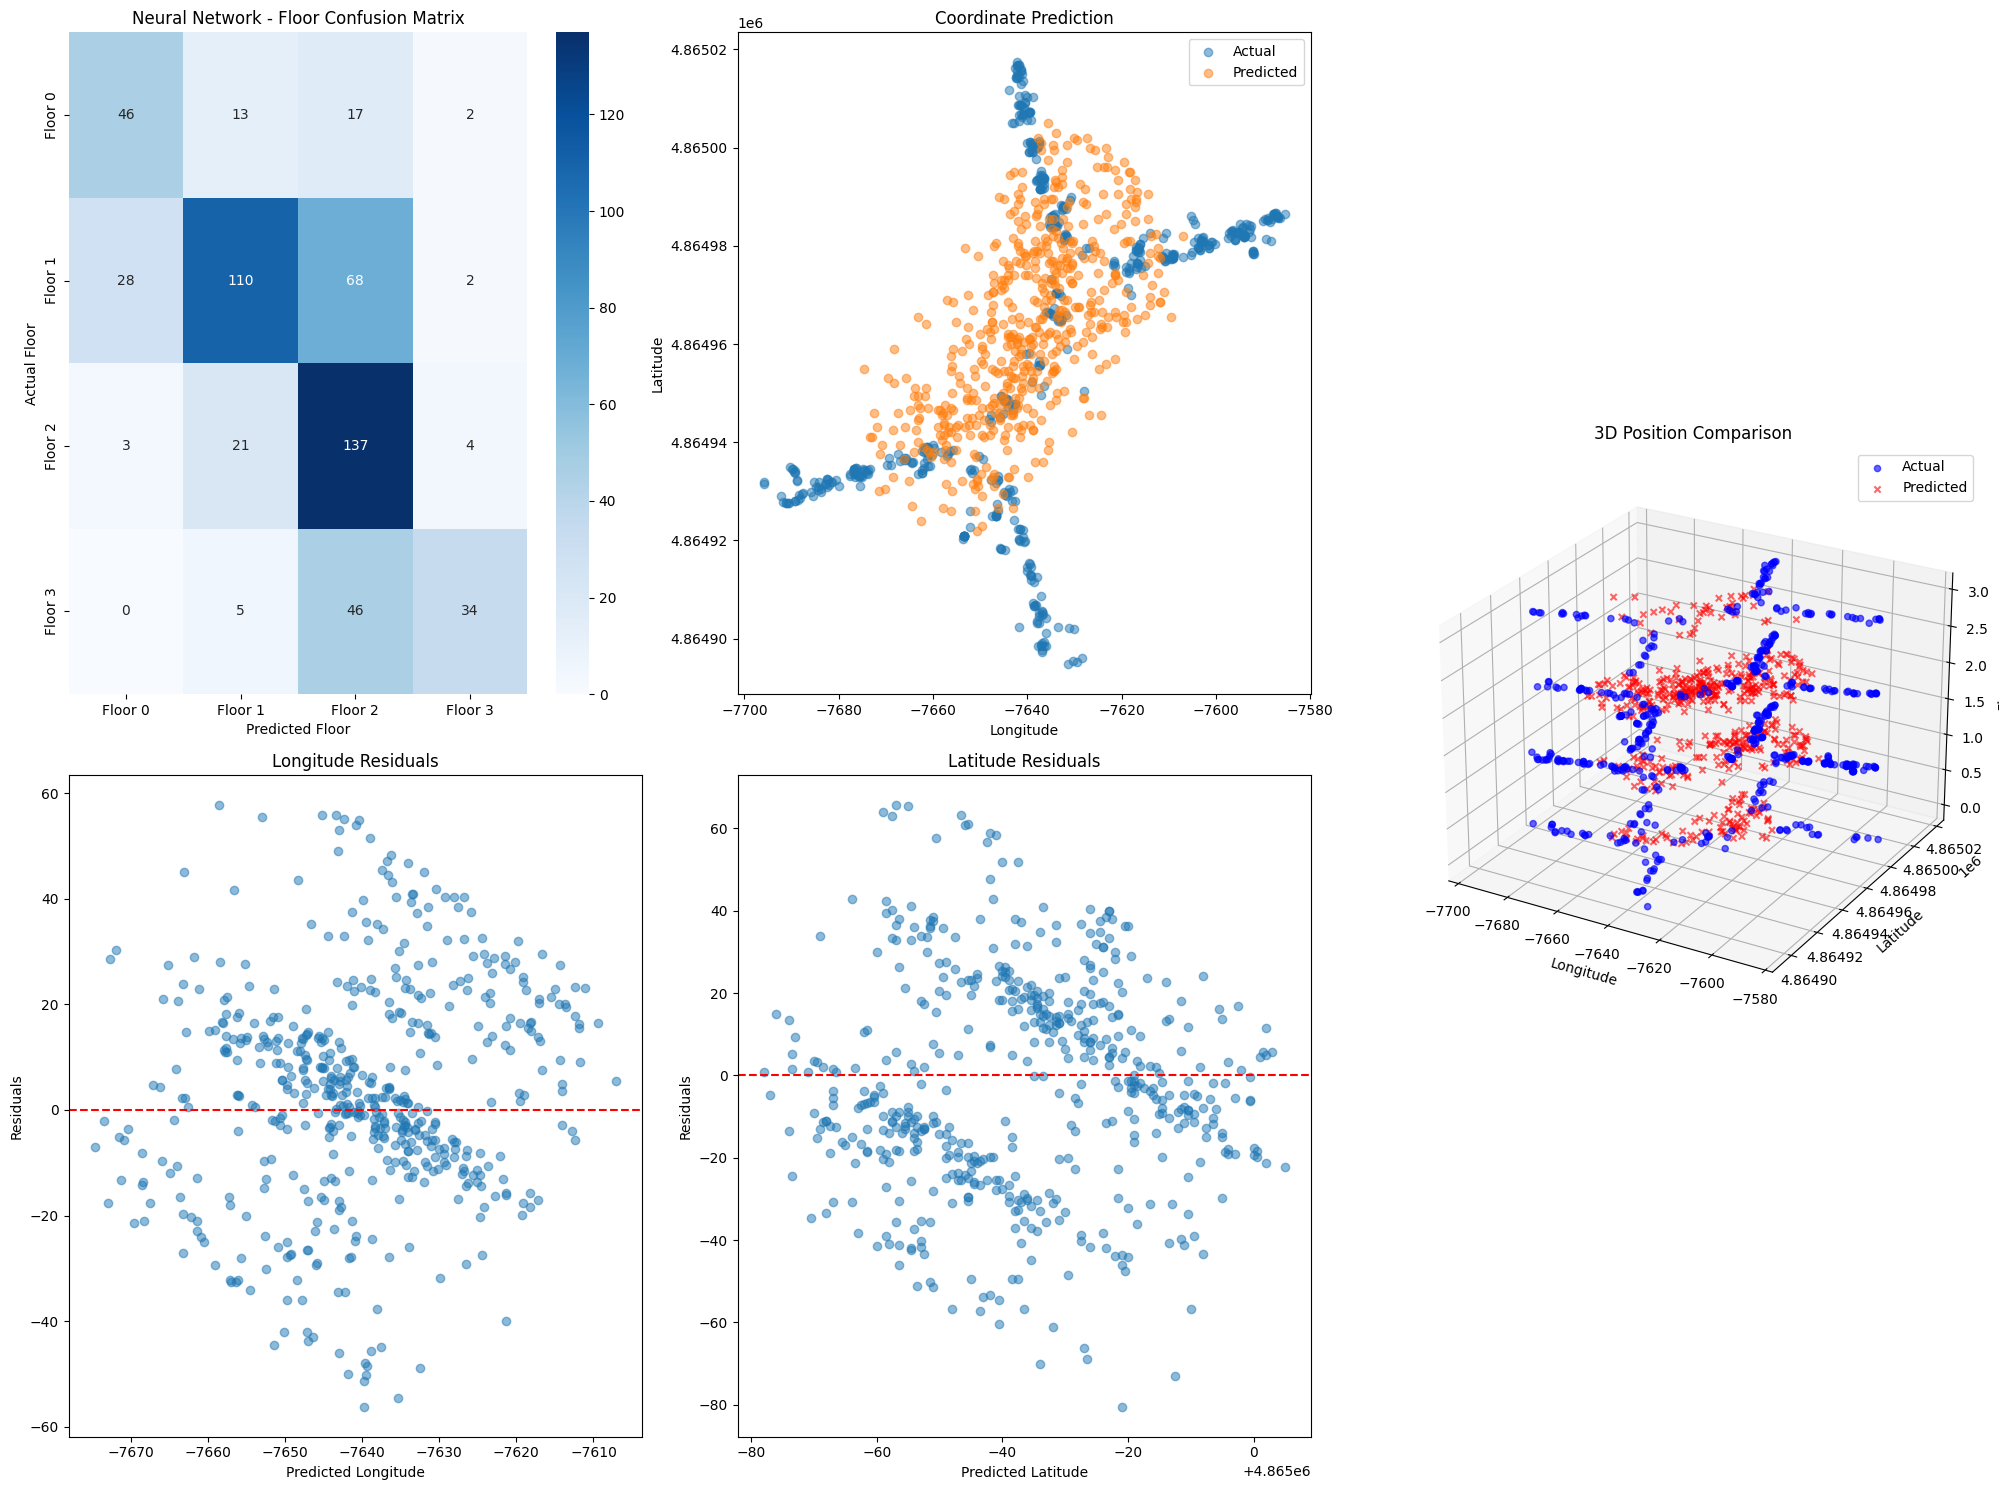


=== Neural Network Performance ===
Coordinates MSE: 566.8225
Coordinates R²: 0.3353
Floor Accuracy: 0.6101

Classification Report:
              precision    recall  f1-score   support

     Floor 0       0.60      0.59      0.59        78
     Floor 1       0.74      0.53      0.62       208
     Floor 2       0.51      0.83      0.63       165
     Floor 3       0.81      0.40      0.54        85

    accuracy                           0.61       536
   macro avg       0.66      0.59      0.59       536
weighted avg       0.66      0.61      0.61       536


=== Final Model Comparison ===
| Model          |     MSE |       R² |   Adj_R² |   Accuracy |
|:---------------|--------:|---------:|---------:|-----------:|
| SVR (RBF)      | 560.707 | 0.347191 | 0.301494 |   0.55597  |
| Neural Network | 566.823 | 0.33529  | 0.288761 |   0.610075 |
| MLP            | 591.484 | 0.310335 | 0.262059 |   0.595149 |


In [ ]:
# ml_3


# Neural Network Model Definition
def create_neural_network(input_shape, n_floors):
    inputs = Input(shape=(input_shape,))
    x = Dense(256, activation='relu')(inputs)
    x = Dense(128, activation='relu')(x)
    
    # Outputs
    coord_output = Dense(2, name='coord_output')(x)
    floor_output = Dense(n_floors, activation='softmax', name='floor_output')(x)
    
    model = Model(inputs=inputs, outputs=[coord_output, floor_output])
    model.compile(
        optimizer='adam',
        loss={
            'coord_output': 'mse',
            'floor_output': 'sparse_categorical_crossentropy'
        },
        metrics={
            'coord_output': ['mse'],
            'floor_output': ['accuracy']
        }
    )
    return model

# Create the neural network model
nn_model = create_neural_network(X_train.shape[1], len(le.classes_))

# Train the nn_model
history = nn_model.fit(
    X_train,
    {'coord_output': y_train_reg_scaled, 'floor_output': y_train_floors},
    validation_data=(X_val, {'coord_output': coord_scaler.transform(y_val_reg), 'floor_output': y_val_floors}),
    epochs=100,
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5)],
    batch_size=64,
    verbose=1
)

# NN_Wrapper class to store predictions
class NN_Wrapper:
    def __init__(self, model, coord_scaler):
        self.model = model
        self.coord_scaler = coord_scaler
        
    def predict_all(self, X):
        """Returns both regression and classification predictions"""
        pred_reg, pred_cls = self.model.predict(X, verbose=0)
        return self.coord_scaler.inverse_transform(pred_reg), np.argmax(pred_cls, axis=1)

# Function to evaluate model performance
def evaluate_model_performance(model, X_test, y_test_reg, y_test_floors, coord_scaler, le, model_name):
   
    plt.figure(figsize=(20, 15))
    
    # Make predictions
    if isinstance(model, NN_Wrapper):  # Neural Network case
        y_pred_reg, y_pred_floors = model.predict_all(X_test)
    else:  # Traditional ML case
        y_pred_reg = model['regressor'].predict(X_test)
        y_pred_reg = coord_scaler.inverse_transform(y_pred_reg)
        y_pred_floors = model['classifier'].predict(X_test)
    
    # Convert to numpy arrays if needed
    y_test_reg = y_test_reg.values if hasattr(y_test_reg, 'values') else y_test_reg
    y_test_floors = np.array(y_test_floors)
    
    # Create formatted floor labels
    floor_labels = [f"Floor {int(i)}" for i in le.classes_]
    
    # Confusion Matrix
    plt.subplot(2, 3, 1)
    cm = confusion_matrix(y_test_floors, y_pred_floors)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=floor_labels, 
               yticklabels=floor_labels)
    plt.title(f'{model_name} - Floor Confusion Matrix')
    plt.xlabel('Predicted Floor')
    plt.ylabel('Actual Floor')
    
    # Coordinate Scatterplot
    plt.subplot(2, 3, 2)
    plt.scatter(y_test_reg[:, 0], y_test_reg[:, 1], alpha=0.5, label='Actual')
    plt.scatter(y_pred_reg[:, 0], y_pred_reg[:, 1], alpha=0.5, label='Predicted')
    plt.title('Coordinate Prediction')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    
    # Residual Plots
    residuals = y_test_reg - y_pred_reg
    
    plt.subplot(2, 3, 4)
    plt.scatter(y_pred_reg[:, 0], residuals[:, 0], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Longitude Residuals')
    plt.xlabel('Predicted Longitude')
    plt.ylabel('Residuals')
    
    plt.subplot(2, 3, 5)
    plt.scatter(y_pred_reg[:, 1], residuals[:, 1], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Latitude Residuals')
    plt.xlabel('Predicted Latitude')
    plt.ylabel('Residuals')
    
    # 4. 3D Visualization
    ax = plt.subplot(2, 3, (3,6), projection='3d')
    ax.scatter(y_test_reg[:, 0], y_test_reg[:, 1], y_test_floors,
              c='blue', marker='o', alpha=0.6, label='Actual')
    ax.scatter(y_pred_reg[:, 0], y_pred_reg[:, 1], y_pred_floors,
              c='red', marker='x', alpha=0.6, label='Predicted')
    """
    # Add error lines
    for i in range(len(y_test_reg)):
        ax.plot([y_test_reg[i,0], y_pred_reg[i,0]],
                [y_test_reg[i,1], y_pred_reg[i,1]],
                [y_test_floors[i], y_pred_floors[i]],
                'gray', alpha=0.2, linestyle='--')"""
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Floor')
    ax.set_title('3D Position Comparison')
    ax.legend()
    ax.view_init(elev=25, azim=-60)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    r2 = r2_score(y_test_reg, y_pred_reg)
    accuracy = accuracy_score(y_test_floors, y_pred_floors)
    adj_r2 = adjusted_r2_score(y_test_reg, y_pred_reg, X_test.shape[1])

    
    print(f"\n=== {model_name} Performance ===")
    print(f"Coordinates MSE: {mse:.4f}")
    print(f"Coordinates R²: {r2:.4f}")
    print(f"Floor Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test_floors, y_pred_floors, target_names=floor_labels))
    
    return {
        'MSE': mse,
        'R²': r2,
        'Adj_R²': adj_r2,
        'Accuracy': accuracy
    }


# Models
models = {
    "SVR (RBF)": {
        'regressor': MultiOutputRegressor(SVR(kernel='rbf')),  # SVR for regression
        'classifier': SVC(kernel='rbf')                       # SVC for classification
    },
    "MLP": {
        'regressor': MLPRegressor(hidden_layer_sizes=(256, 128), early_stopping=True),
        'classifier': MLPClassifier(hidden_layer_sizes=(256, 128), early_stopping=True)
    },
    "Neural Network": NN_Wrapper(nn_model, coord_scaler)  
}
results = []
for name, model in models.items():
    print(f"\n{'='*40}\nEvaluating {name}\n{'='*40}")
    
    if name != "Neural Network":
        model['regressor'].fit(X_train, y_train_reg_scaled)
        model['classifier'].fit(X_train, y_train_floors)
    
    metrics = evaluate_model_performance(
        model, X_test_new, y_test_reg_new, y_test_cls_new, # X_val, y_val_reg, y_val_floors can we swapped with X_test_new, y_test_reg_new, y_test_cls_new
        coord_scaler, le, name
    )
    results.append({'Model': name, **metrics})

# Display final comparison
results_df = pd.DataFrame(results).sort_values('MSE')
print("\n=== Final Model Comparison ===")
print(results_df.to_markdown(index=False))

From the output of this cell, we can see that the SVR(RBF) model performs the best in terms of adjusted R2 score but has the lowest accuracy while the neural network is the most accurate. 

Since the model's purpose is to predict the locations where crowds might gather, the neural network model performs the best and is therefore recommended to be used for crowd analysis.

Future considerations: Should the model be trained on a larger dataset with other environmental and temporal factors, its performance would surely be boosted.